In [ ]:
"""
@author: Ajay
"""

In [1]:
from pyNM.spiking_multiclass_classifier import *

In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from pyNM.cf_matrix import make_confusion_matrix
from plot_metric.functions import MultiClassClassification
import seaborn as sns
from random import *
get_ipython().run_line_magic('matplotlib', 'inline')

In [3]:
def run_classifier():
    torch.multiprocessing.freeze_support()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)

    # load iris dataset
    iris_df = pd.read_csv('../data/iris_data.csv')
    print(iris_df.shape)
    print(iris_df.head())

    # transforming target/class to numeric

    #iris_df.loc[iris_df.species=='Iris-setosa','species'] = 0
    #iris_df.loc[iris_df.species=='Iris-versicolor','species'] = 1
    #iris_df.loc[iris_df.species=='Iris-virginica','species'] = 2

    #checking class distribution
    iris_df['target'].value_counts().plot.bar(legend='Class Distribution')

    # final dataset

    X = iris_df.iloc[:,0:4]
    y = iris_df.iloc[:,4]
    #print(y)
   
    # Scale data to have mean '0' and variance '1' 
    # which is importance for convergence of the neural network
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Split the data set into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values.astype(float), test_size=0.2, random_state=2)
    
    #####################
    spiking_model = SpikingNeuralNetwork(device, X_train.shape[1], num_class=3, n_time_steps=64, begin_eval=0)
    #####################
    optimizer = torch.optim.Adam(spiking_model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    loss_fn   = nn.CrossEntropyLoss()
    print(spiking_model)
    
    # Train the model
    EPOCHS  = 100
    X_train = Variable(torch.from_numpy(X_train)).float()
    y_train = Variable(torch.from_numpy(y_train)).long()
    X_test  = Variable(torch.from_numpy(X_test)).float()
    y_test  = Variable(torch.from_numpy(y_test)).long()

    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    for epoch in tqdm(range(EPOCHS)): 
        y_pred = spiking_model(X_train) #model
        #print(y_pred)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()

        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_pred = spiking_model(X_test) #model
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
    
         
        if epoch % 10 == 0:
            print('number of epoch', epoch, 'loss', loss.item()) 
            print('number of epoch', epoch, 'accuracy', correct[0])
        
    # Plot Accuracy and Loss from Training
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

    ax1.plot(accuracy_list)
    ax1.set_ylabel("validation accuracy")
    ax2.plot(loss_list)
    ax2.set_ylabel("validation loss")
    ax2.set_xlabel("epochs");
    
    
    # Show ROC Curve
    plt.figure(figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')

    # One hot encoding
    enc = OneHotEncoder()
    Y_onehot = enc.fit_transform(y_test[:, np.newaxis]).toarray()

    with torch.no_grad():
        y_pred = spiking_model(X_test).numpy() #model
        #pred = torch.argmax(y_pred).type(torch.FloatTensor)
        fpr, tpr, threshold = roc_curve(Y_onehot.ravel(), y_pred.ravel())

    plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc(fpr, tpr)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend();
    
    print(y_test)
    print(np.argmax(y_pred, axis=1))
    y_pred_ = np.argmax(y_pred, axis=1)
    
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred_)
    print(cf_matrix)
    make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False, title='IRIS CF Matrix')
    
    # report
    # Visualisation of plots
    mc = MultiClassClassification(y_test, y_pred, labels=[0, 1, 2])
    plt.figure(figsize=(13,4))
    plt.subplot(131)
    mc.plot_roc()
    plt.subplot(132)
    mc.plot_confusion_matrix()
    plt.subplot(133)
    mc.plot_confusion_matrix(normalize=True)

    plt.savefig('../figures/images/plot_multi_classification.png')
    plt.show()

    mc.print_report()

cpu
(150, 5)
   sepal_length  sepal_width  petal_length  petal_width  target
0           5.1          3.5           1.4          0.2       0
1           4.9          3.0           1.4          0.2       0
2           4.7          3.2           1.3          0.2       0
3           4.6          3.1           1.5          0.2       0
4           5.0          3.6           1.4          0.2       0
SpikingNeuralNetwork(
  (input_conversion): InputDataToSpikingPerceptronLayer()
  (layer1): SpikingNeuronLayer(
    (fc): Linear(in_features=4, out_features=100, bias=True)
  )
  (layer2): SpikingNeuronLayer(
    (fc): Linear(in_features=100, out_features=3, bias=True)
  )
  (output_conversion): OutputDataToSpikingPerceptronLayer()
)


  0%|          | 0/100 [00:00<?, ?it/s]

number of epoch 0 loss 1.1888130903244019
number of epoch 0 accuracy tensor(0.)
number of epoch 10 loss 1.0742288827896118
number of epoch 10 accuracy tensor(0.)
number of epoch 20 loss 0.9833044409751892
number of epoch 20 accuracy tensor(1.)
number of epoch 30 loss 0.8954691290855408
number of epoch 30 accuracy tensor(1.)
number of epoch 40 loss 0.8114181160926819
number of epoch 40 accuracy tensor(1.)
number of epoch 50 loss 0.7300552725791931
number of epoch 50 accuracy tensor(1.)
number of epoch 60 loss 0.6591152548789978
number of epoch 60 accuracy tensor(1.)
number of epoch 70 loss 0.5944210886955261
number of epoch 70 accuracy tensor(1.)
number of epoch 80 loss 0.5397689342498779
number of epoch 80 accuracy tensor(1.)
number of epoch 90 loss 0.4874097406864166
number of epoch 90 accuracy tensor(1.)
tensor([0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1,
        1, 0, 0, 2, 0, 2])
[0 0 2 0 0 2 0 2 2 0 0 0 0 0 1 2 0 1 2 1 2 1 2 1 1 0 0 2 0 2]
[[14  0  0]
 

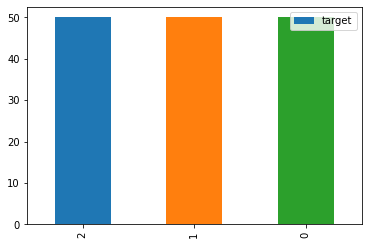

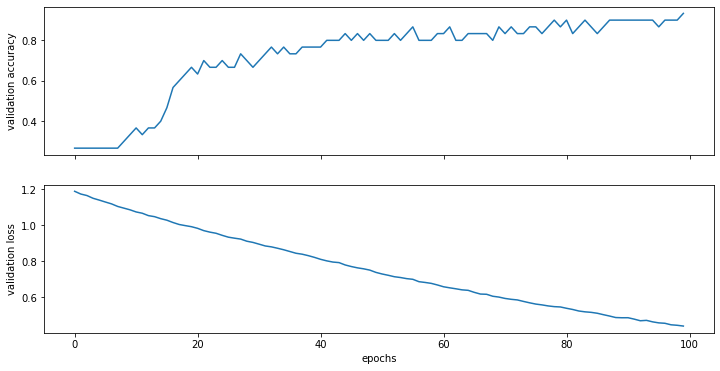

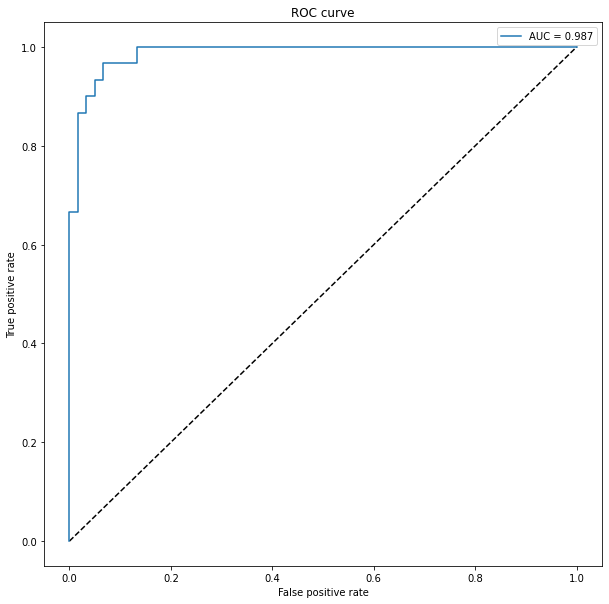

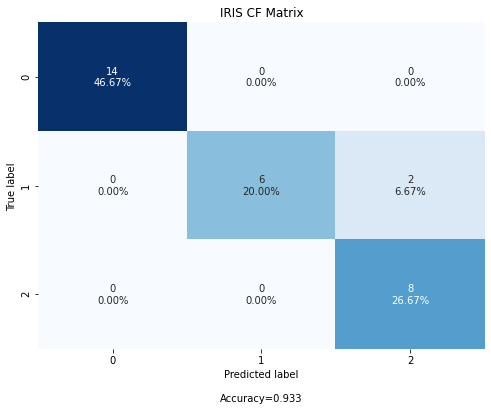

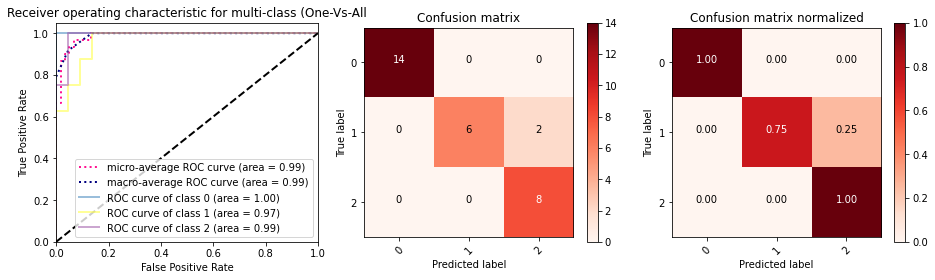

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.75      0.86         8
           2       0.80      1.00      0.89         8

    accuracy                           0.93        30
   macro avg       0.93      0.92      0.92        30
weighted avg       0.95      0.93      0.93        30



In [4]:
if __name__ == '__main__':
    run_classifier()